# Diseño de filtros digitales

## Tabla de contenidos

* [1. Introducción](#introduction)
* [2. Filtros FIR](#fir-filters)
* [3. Tipos de respuestas en frecuencia](#frequency-responses)
* [4. Características de los filtros](#filter-characteristics)
    * [4.1 Respuesta en magnitud](#magnitude-response)
    * [4.2 Respuesta en fase](#phase-response)
* [5. Métodos de diseño de filtros](#filter-design-methods)
    * [Método de ventanas](#window-method)
    * [Algortimo Parks-McClellan](#parks-mcclellan)
    * [Método de mínimos cuadrados](#least-squares)
* [6. Conclusiones](#conclusion)

## Referencias

[1] - T.W. Parks and C.S. Burrus, "Digital Filter Design", Wiley, 1987.

[2] - J.G. Proakis and D.G. Manolakis, "Digital Signal Processing", Prentice-Hall, 1996.


## 1. Introducción <a class="anchor" id="introduction"></a>

Los filtros digitales son un elemento clave del procesamiento digital de señales (DSP). Estos filtros se implementan usando únicamente operaciones de multiplicación, suma y retraso. Su rol en un sistema DSP es atenuar ciertas bandas de frecuencias dentro de una señal a la vez que se deja pasar sin cambiar el resto de bandas.

Existen dos algoritmos principales para filtros digitales, Finite Impulse Response (FIR) y Infinite Impulse Response (IIR). Normalmente se prefieren los filtros FIR porque son más estables y fáciles de restringir a una respuesta lineal. Por estas razones, nos centraremos en el diseño de filtros FIR.

Existen varias técnicas de diseño de filtros FIR disponibles, cada una de ellas produciendo filtros con diferentes características. En este notebook analizaremos algunas de las más comunes y analizaremos las diferencias entre ellas.

## 2. Filtros FIR <a class="anchor" id="fir-filters"></a>

Un filtro FIR filter convoluciona una señal de entrada con una respuesta a impulso, pudiéndose expresar de forma matemática como:

$y(k) = \sum_{n=0}^{N-1} h_n x(k-n)$

donde $x$ es la señal de entrada, $k$ es el índice la muestra y $h$ expresa las muestras (coeficientes) de la respuesta impulso.

La respuesta impulso cambia la forma de una señal, atenuando ciertas frecuencias cuando se realiza la convolución. A la hora de diseñar los filtros, la salida de los algoritmos son los coeficientes de esas respuestas impulso.

Una respuesta impulso es una respresentación en un dominio temporal. Esto hace extremadamente dificil (si no imposible) determinar el efecto que tendrá ante una señal a simple vista.

Por ejemplo, la figura 1 muestra dos respuestas impulso; una atenua las frecuencias altas, la otra atenua las frecuencias bajas. Es muy complicado saber cual es cual y decir que frecuencias pasarán y cuales serán atenuadas.

<figure>
<img src='./images/filter_impulse_responses.svg' height='auto' width='auto'/>
    <figcaption><b>Figura 1: Dos filtros de respuesta a impulso.</b></figcaption>
</figure>

Por esta razón es mucho mejor pensar en un filtro en términos de su respuesta en **frecuencia** en lugar de su respuesta impulso.

## 3. Tipos de respuesta en frecuencia <a class="anchor" id="frequency-responses"></a>

Según la respuesta en frecuencia, los filtros pueden clasificarse en: Pasa Baja (Low Pass), Pasa Alta (High Pass), Pasa Banda (Band Pass) y Stop Banda (Band Stop), indicando que frecuencias permite el filtro que "pasen" sin cambiar y cuales son atenuadas.

La figura 2 nos muestra un ejemplo de cada una de las cuatro respuestas en frecuencia. En estos ejemplos, la frecuencia de corte (el punto an el cual las frecuencias de una señal de entra pasan o son atenuadas) está en el centro de la banda de frecuencias. En la práctica, la frecuencia de corte puede ser cualquier punto arbitrario.

<figure>
<img src='./images/filter_responses.svg' height='auto' width='auto'/>
    <figcaption><b>Figura 2: Las respuestas en frecuencia de los cuatro filtros.</b></figcaption>
</figure>

La motivación del filtrado es altirar la composición de frecuencias de una señal, atenuando aquellas frecuencias no deseadas.

## 4. Características de un filtro <a class="anchor" id="filter-characteristics"></a>

Cuando se diseña un filtro se hace en función a una especificación en donde ser requiere una determinada respuesta en frecuencia. Por tanto, dada una especificación la labor de un diseñador será la de generar un filtro digital adecuado.

La figure 2 muestra la respuesta en frecuencia de los cuatro tipos de filtro más comunes en términos de su magnitud.

Un filtro se caracteriza por dos tipos de respuesta diferente: la respuesta en magnitud y la respuesta en fase. La respuesta en magnitud determina el cambio absoluto en la ganancia que experimetna la señal en todo su rango de frecuencias. La respuesta en fase determina el desplazamiento de fase experimentado por la señal en frecuencias específicas.

### 4.1 Respuesta en magnitud <a class="anchor" id="magnitude-response"></a>

La respuesta en magnitud de un filtro se describe usualmente por tres características: **Rizado en la banda de paso**, **Atenuación en la banda de parada** y **Ancho de banda de la transición**, tal y como se muestra para un filtro pasa alta en la figura 3. *Nota* es usual mostrar el eje y de la respuesta en magnitud en dB para entender mejor como se comporta el filtro en la banda de parada.

<figure>
<img src='./images/filter_characteristics.svg' height='auto' width='auto'/>
    <figcaption><b>Figura 3: Características de la respuesta en magnitud de un filtro.</b></figcaption>
</figure>

Un filtro ideal tendría un rizado de cero en la banda de paso, atenuación infinita en la banda de parada y un ancho de banda de la zona de transición infinitamente pequeño. Su respuesta en frecuencia serría como una función rectangular tal y como se muestra en la figura 4.

<figure>
<img src='./images/ideal_filter_response.svg' height='auto' width='auto'/>
    <figcaption><b>Figura 4: Respuesta en frecuencia de un filtro pasa alta ideal.</b></figcaption>
</figure>

Desafortunadamente, no es posible implementar un filtro ideal, por lo que tendremos que tomar ciertos compromisos a la hora de diseñar el filtro.

Veamos un filtro muy simple y como cambiando la longitud del filtro podemos cambiar la respuesta en frecuencia de un filtro pasa baja. Usaremos la función ```firwin2``` (de la clase ```signal``` de ```SciPy```) para diseñar este filtro.

En primer lugar necesitamos importar la bibliteca Signal.

In [9]:
!pip install scipy

In [1]:
from scipy import signal

Ahora podemos definir los parámetros del filtro.

In [2]:
fc = 0.2 # normalised cutoff frequency (% of Nyquist)
N = 101 # length of filter (number of coefficients)

freq = [0, fc, fc, 1] # frequency sampling points of filter (up to Nyquist)
gain = [1, 1, 0, 0] # filter gains at frequency sampling points

Las variables ```freq``` y ```gain``` son listas que describen nuestra respuesta en frecuencia *ideal*.

```freq``` le dice a la función que diseña el filtro en que frecuencias estamos interesados. Las frecuencias que se introducen están normalizadas con respecto a la frecuencia de Nyquist (la mitad de la frecuencia de muestreo).

```gain``` le indica a la función que amplitud queremos a las frecuencias indicadas en ```freq```. Para un filtro pasa baja esto significa la ganancia completa hasta la frecuencia de corte y una ganancia de cero para el resto de frecuencias en adelante. (usamos ```fc``` dos veces en ```freq``` para obtener una banda de transición lo más ajustada que se pueda).

A continuación introducimos estos parámetros en ```firwin2``` para crear el filtro.

In [3]:
lpf = signal.firwin2(N, freq, gain)

Ahora para obtener la respuesta en frecuencia del fitro usamos la FFT. La biblioteca de Python ```Numpy``` incluye un algoritmo para la FFT que podemos usar.

In [4]:
import numpy as np

def get_normalised_fft(x, NFFT):
    X = np.fft.fft(x,NFFT)
    return X/max(abs(X)) # normalise

In [5]:
NFFT = 4096 # FFT length
nf = np.linspace(0, 2, NFFT)

lpf_fft = get_normalised_fft(lpf, NFFT)
lpf_fft_db = 20*np.log10(abs(lpf_fft)) # convert to dB

Después podemos usar la biblioteca de Python ```matplotlib``` para dibujar nuestra respuesta en frecuencia.

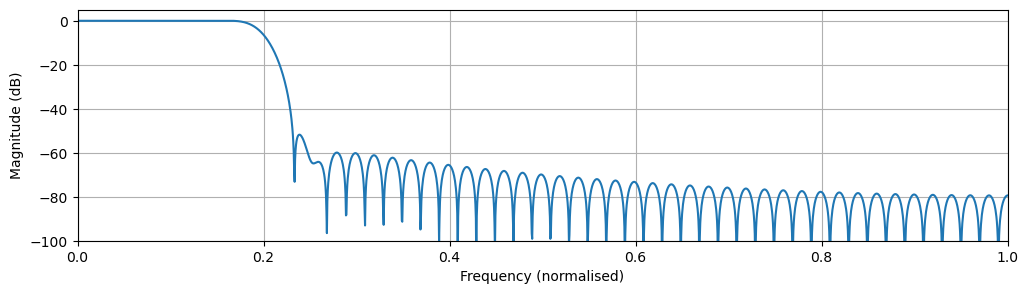

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,3))
plt.xlabel('Frequency (normalised)')
plt.ylabel('Magnitude (dB)')
plt.xlim(0,1)
plt.ylim(-100,5)
plt.grid(True)

plt.plot(nf, lpf_fft_db)
plt.show()

Podemos ver que la atenuación en la banda de parada es de, aproximadamente, 50dB, mientras que la banda de transición es de alrededor del 2.5% del ratio de muestreo. El rizado en la banda de paso es demasiado pequeño para verse, así que podemos usar el parámetro *ylim* para hacer un zoom en la siguiente celda.

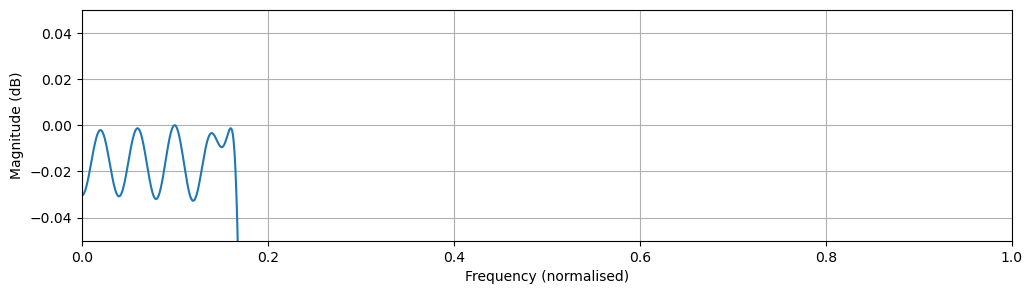

In [7]:
plt.figure(figsize=(12,3))
plt.xlabel('Frequency (normalised)')
plt.ylabel('Magnitude (dB)')
plt.xlim(0,1)
plt.ylim(-0.05,0.05)
plt.grid(True)

plt.plot(nf, lpf_fft_db)
plt.show()

Como se puede observar, el rizado máximo en la banda de paso es de unos 0.03dB (un valor muy bajo).

Intenta cambiar la longitud del filtro y observa como afecta a la respuesta en frecuencia. Deberías observar que dicha frecuencia mejora al aumentarse la longitud del filtro.

### 4.2 Respuesta en fase <a class="anchor" id="phase-response"></a>



## 5. Métodos de Diseño de filtros <a class="anchor" id="filter-design-methods"></a>


### 5.1 Método de ventana <a class="anchor" id="window-method"></a>



### 5.2 Algoritmo Parks-McClellan <a class="anchor" id="parks-mcclellan"></a>



## 6. Conclusiones <a class="anchor" id="conclusion"></a>

